## The optimal low-resistance network
> **`gradnet` concepts demonstrated below**
> - Instantiating and configuring a `GradNet` model for network optimization
> - Implementing and passing custom loss functions to the optimizer
> - Training the network structure using `trainer.fit`
> - Converting the learned network to NetworkX format for further analysis
### Problem setup
Given a fixed wiring budget, how do you build a network with least resistance? That is we want the network with fixed total edge-weight which minimizes the Resistance Distance (i.e., Kirchhoff index). Resistance Distance is computed as the sum of all effective pair-wise resistances in the network

$$ \sum_{i<j} \Omega_{ij} = N\sum_{k=2}^N \frac{1}{\lambda_k}$$

Here $\lambda_k$ are the eigenvalues of the Laplacian matrix for the network ($L_{ij}=\sum_k A_{ik} - A_{ij}$). Note that $\lambda_0=0$, but it is skipped in the sum. 
Edge-weights $A_{ij}$ correspond to the conductences of the given edge, which is the inverse of resistance.

### GradNet optimization

In [1]:
from gradnet import GradNet, trainer
import torch

N = 30*50
budget_per_node = 1.0

gn = GradNet(num_nodes=N, budget=budget_per_node*N, rand_init_weights=0.9)

# define the loss function
def loss_fn(gn):
    A = gn()  # get the adjacency matrix
    L = torch.diag(A.sum(dim=1)) - A  # compute the graph Laplacian
    eigs = torch.linalg.eigvalsh(L)  # compute the eigenvalues
    r = torch.sum(1.0 / eigs[1:])  # compute the resistance distance
    # r is missing a constant factor N, but that doesn't change the optimization landscape
    return r

trainer.fit(gn=gn, loss_fn=loss_fn, num_updates=100, optim_kwargs={"lr": 0.1}, accelerator="cpu");

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Updates:   0%|          | 0/100 [00:00<?, ?it/s]


  | Name | Type    | Params | Mode 
-----------------------------------------
0 | gn   | GradNet | 2.2 M  | train
-----------------------------------------
2.2 M     Trainable params
0         Non-trainable params
2.2 M     Total params
9.000     Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=100` reached.


### Plot the results

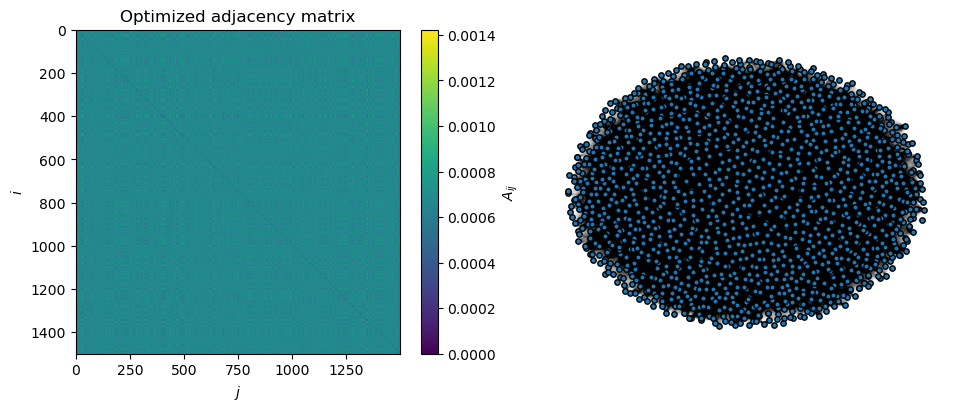

In [2]:
from matplotlib import pyplot as plt
import networkx as nx
from gradnet.utils import to_networkx
# Convert adjacency matrix to NetworkX graph
A = gn().detach().cpu().numpy()

fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 4), constrained_layout=True)

# Left: plot the adjacency matrix as a heatmap
im0 = ax0.imshow(A)
fig.colorbar(im0, ax=ax0, label="$A_{ij}$")
ax0.set(title="Optimized adjacency matrix", xlabel="$j$", ylabel="$i$")

# Right: plot the networkx graph
net = to_networkx(gn)
edge_widths = list(nx.get_edge_attributes(net, 'weight').values())
nx.draw_spring(net, ax=ax1, nodelist=sorted(net.nodes()),
               node_size=15, width=edge_widths, edgecolors="black")


We find that the uniform, conpletely connected graph is the optimal pattern for minimizing the resistance distance of the network.

### Restricting tunable edges to a grid

In [11]:
import numpy as np
# Build a 2D grid mask (rows*cols = N), train, and plot with grid layout
rows = 20
cols = N // rows
assert rows * cols == N, "Choose rows, cols such that rows*cols == N"

mask = torch.zeros((N, N))
for r in range(rows):
    for c in range(cols):
        i = r * cols + c
        if r + 1 < rows:
            j = (r + 1) * cols + c
            mask[i, j] = mask[j, i] = 1
        if c + 1 < cols:
            j = r * cols + (c + 1)
            mask[i, j] = mask[j, i] = 1

gn_grid = GradNet(num_nodes=N, budget=budget_per_node * N, mask=mask, rand_init_weights=0.9)
trainer.fit(gn=gn_grid, loss_fn=loss_fn, num_updates=100, optim_kwargs={"lr": 0.1}, accelerator="cpu")

# Plot adjacency heatmap and grid layout (edge widths = weights)
A_grid = gn_grid().detach().cpu().numpy()

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Updates:   0%|          | 0/100 [00:00<?, ?it/s]


  | Name | Type    | Params | Mode 
-----------------------------------------
0 | gn   | GradNet | 2.2 M  | train
-----------------------------------------
2.2 M     Trainable params
0         Non-trainable params
2.2 M     Total params
9.000     Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=100` reached.


/var/folders/72/79vqt54j447byqmvb80g_n3w0000gn/T/ipykernel_55715/2007804448.py:9: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  edges = nx.draw_networkx_edges(


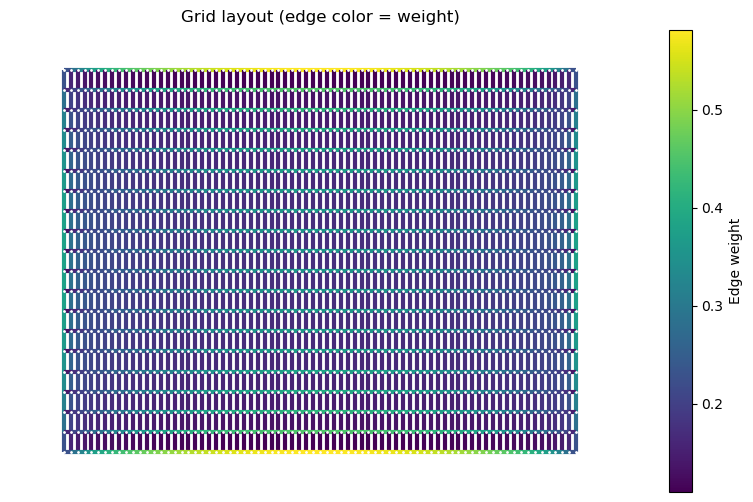

In [19]:
net_grid = to_networkx(gn_grid)
edge_weights = np.array(list(nx.get_edge_attributes(net_grid, 'weight').values()))
pos = {r * cols + c: (c, -r) for r in range(rows) for c in range(cols)}

# Create figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Draw graph on the same axis
edges = nx.draw_networkx_edges(
    net_grid, pos=pos, ax=ax,
    edge_color=edge_weights, edge_cmap=plt.cm.viridis, width=3
)
nx.draw_networkx_nodes(
    net_grid, pos=pos, ax=ax,
    nodelist=sorted(net_grid.nodes()), node_color="white", node_size=1
)

ax.set(title="Grid layout (edge color = weight)")
ax.set_axis_off()

# Add colorbar linked to edges
sm = plt.cm.ScalarMappable(
    cmap=plt.cm.viridis,
    norm=plt.Normalize(vmin=edge_weights.min(), vmax=edge_weights.max())
)
sm.set_array([])
fig.colorbar(sm, ax=ax, label="Edge weight")

plt.show()
